# Monte Carlo Simulation for BHP
Forecast BHP price based on historical averages and volatility


## Methodology
- Use historical data for forecast of future price
- Estimating 1 year forecast by using 1 years of historical data - daily close price.
- Calculate mean and standard deviation of daily returns (%) for historical dataset
- Perform Monte Carlo simulation using log-normal distribution
- Simulate possible prices at trading day *n* into the future
- Simulate at least 1000 possible prices at day *n*
- Forecast will be the average price of all simulated prices

In [75]:
import random
import numpy as np
import pandas as pd
import pandas.io.data as web
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_style("dark")
sns.set_context("talk")

#### Approximate trading days in a year

In [76]:
DAYSINYEAR = 365
WEEKSINYEAR = 52
AUSPUBLICHOLIDAYS = 8
yearTradingDays = DAYSINYEAR - (WEEKSINYEAR*2) - AUSPUBLICHOLIDAYS
print("Approx. Trading Days In Year:", yearTradingDays)

Approx. Trading Days In Year: 253


#### Import historical BHP Prices
 - Import data from Yahoo
 - If forecasting for *n* days, import *n* days of historical data
 - Plot daily close prices
 - Get summary statistics

In [186]:
n = yearTradingDays
print("Trading days in a year: %s" %n)

Trading days in a year: 253


In [78]:
# Date range for historical data
start = datetime.date.today() - datetime.timedelta(days=n)
end = datetime.date.today() 

In [79]:
dataBHP = web.DataReader("BHP.AX", 'yahoo', start,end)

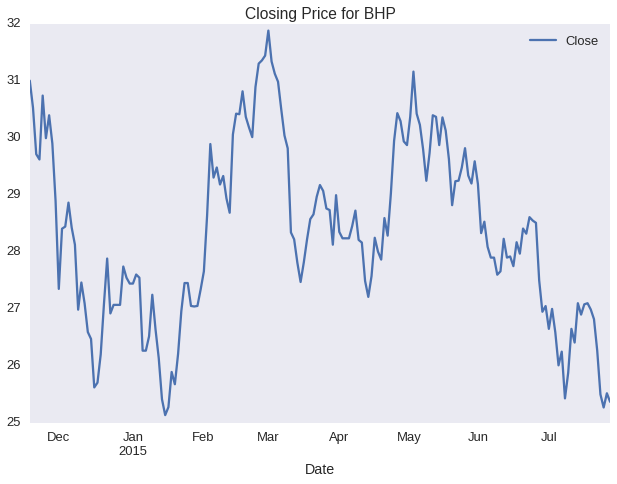

In [80]:
dataBHP.Close.plot(legend=True,title="Closing Price for BHP")

#### Closing price statistics

In [81]:
dataBHP.Close.describe()

count    181.000000
mean      28.313836
std        1.559780
min       25.136500
25%       27.080100
50%       28.238800
75%       29.590000
max       31.883100
Name: Close, dtype: float64

#### Let's analyse daily % returns for the dataset.
- Plot daily % returns
- Get summary statistics

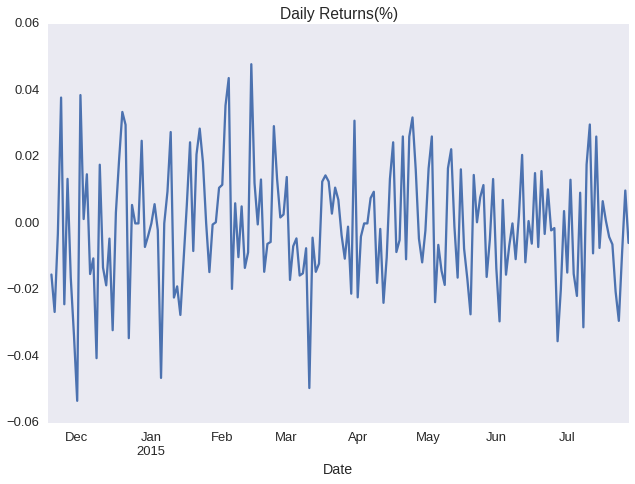

In [82]:
dataBHP.Close.pct_change().plot(title="Daily Returns(%)")

#### Percentage Return Statistics

In [83]:
dataBHP.Close.pct_change().describe()

count    180.000000
mean      -0.000948
std        0.018262
min       -0.053363
25%       -0.013415
50%       -0.001844
75%        0.012237
max        0.047885
Name: Close, dtype: float64

#### Remember the latest price for BHP. We will use this as a starting point to forecast prices

In [84]:
dataBHPlastPrice = dataBHP.Close.iloc[-1]
print(dataBHPlastPrice)

25.37


#### Some helper functions for the Monte Carlo Simulation
- Stock prices generally have a log-normal distribution
- *simulate* will generate a single possible % return based on mean, standard deviation

In [85]:
def lognormal(mu, std_dev):
    """Apply the log-normal distribution."""
    return random.lognormvariate(mu, std_dev)

def simulate(days, start_price,mu, std_dev, distribution):
    """Simulate the asset for the specified number of days."""
    price = start_price
    for day in range(days):
        price = max(0, price * distribution(mu, std_dev))
    return price

#### Keep a running table of means and standard deviations of BHP Daily Percentage Returns
- If we are forecasting for day *n* into the future, calculate the mean and standard deviation of the previous *n* days
- Use this mean and standard deviation to generate *s* possible prices for day *n*

In [86]:
muList = pd.Series([dataBHP.Close.pct_change().iloc[-i-1:].mean() for i in range(n)],name='mu')

In [87]:
stdList =[dataBHP.Close.pct_change().iloc[-i-1:].std() for i in range(n)]
stdList[0] = 0.0
stdList = pd.Series(stdList,name='stdev')

#### Generate *s* possible prices for each trading day

In [88]:
s = 1000

#### Intialize a table which will contain all the forecasted prices

In [89]:
runningStats = pd.concat([muList,stdList], axis=1)

In [90]:
np.full([n,s], None)

forecasts = pd.DataFrame(data=np.empty([n,s]), columns=[col for col in range(s)],
                       index=[row for row in range(n)])

#### Run the Monte Carlo Simulation to populate the forecast table

In [91]:
%%time
for d in range(n):
    for trial in range(s):
        forecasts.iloc[d,trial]=simulate(days=d, 
                                         start_price=dataBHPlastPrice, 
                                         mu=runningStats.mu.iloc[d],
                                         std_dev=runningStats.stdev.iloc[d], 
                                         distribution=lognormal)

CPU times: user 2min 20s, sys: 54.9 ms, total: 2min 20s
Wall time: 2min 21s


In [190]:
forecasts.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,...,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000
1,25.223668,25.120435,25.121384,25.587274,25.495590,25.056184,25.298697,25.049001,25.467477,25.668717,...,25.687612,25.573548,24.900347,25.837232,25.120403,25.079242,25.747038,25.157751,25.244043,25.696968
2,25.001575,25.248120,25.418041,25.223856,25.845389,25.319636,25.634596,24.900194,25.445448,25.332547,...,25.526203,25.877076,25.632775,25.207469,25.583655,24.887442,25.186516,25.641559,24.708830,25.683142
3,24.209654,25.295580,24.742405,24.326965,25.187749,25.432018,24.726050,24.096910,25.161137,24.743776,...,23.531720,25.276306,23.958840,24.258851,24.855158,24.721561,24.872977,24.865159,25.426719,24.934920
4,23.543900,24.163383,24.631092,22.402921,23.946694,23.968164,24.840113,25.066428,24.591945,24.500161,...,25.221463,25.167408,25.630464,24.587129,24.992465,23.461666,24.487991,24.673947,24.403559,24.589208


#### Plot the forecast table
- Each day has 1000 generated price samples
- A lot of uncertainty as we get further away from today's price

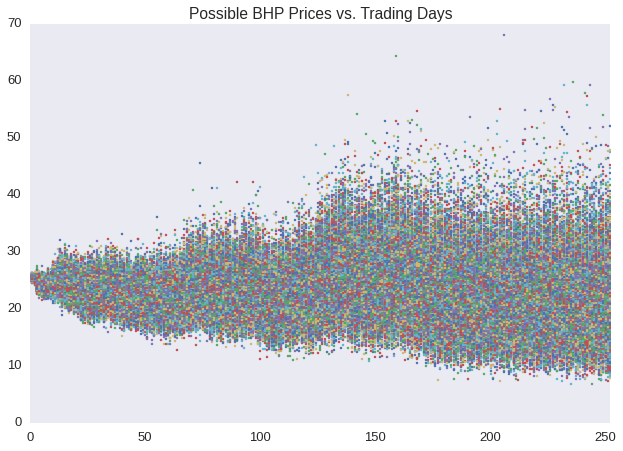

In [92]:
forecasts.plot(style='.', legend=False, linewidth=0.5,title="Possible BHP Prices vs. Trading Days", ms=5)

#### Let's look at the distribution of possible prices at a point in time
- Example: n=100 (100 trading days away)
- Take a slice at n=100 from the graph above
- Visualise distribution of that slice of samples

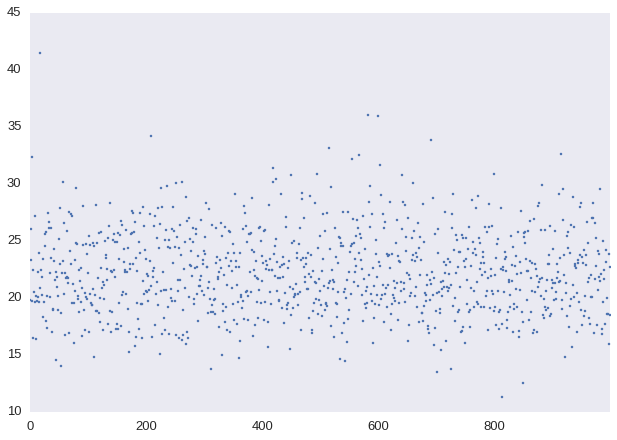

In [93]:
forecasts.iloc[100].plot(style=".", ms=5.0)

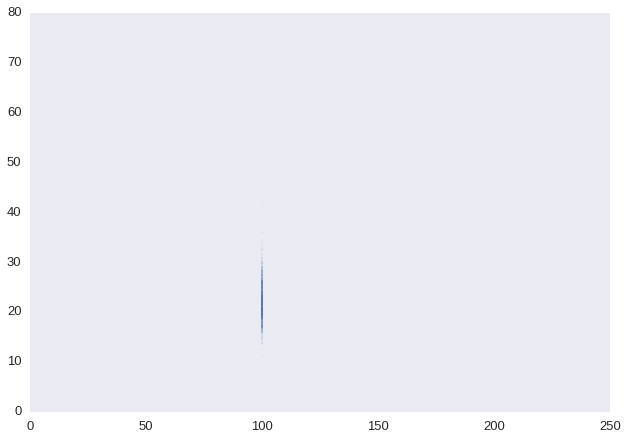

In [94]:
a = forecasts.iloc[100]
b = [100 for i in range(s)]
plt.xlim(0,250)
plt.ylim(0,80)
plt.plot(b,a, "o",ms=0.5)

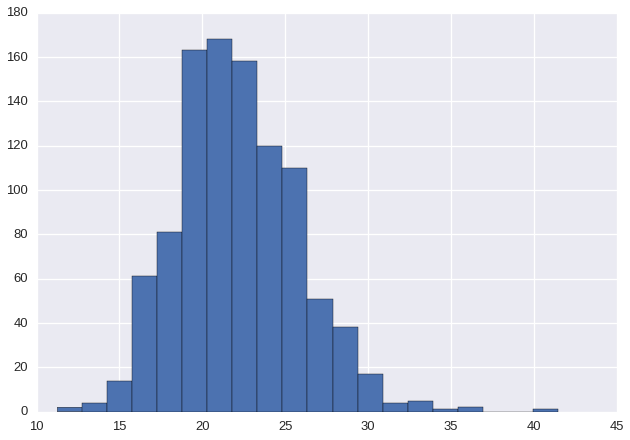

In [95]:
forecasts.iloc[100].hist(bins=20)

In [96]:
forecasts.iloc[100].describe()

count    1000.000000
mean       22.186882
std         3.622278
min        11.253414
25%        19.658253
50%        21.899652
75%        24.516146
max        41.426312
Name: 100, dtype: float64

#### Let's look at the stats for n=200 (200 trading days away)
- Standard Deviation is signficantly higher at n=200 than at n=100 - indicating greater uncertainty of what the price will be further away in time

In [97]:
forecasts.iloc[200].describe()

count    1000.000000
mean       21.468718
std         5.425520
min         8.533135
25%        17.412582
50%        20.750131
75%        24.687042
max        44.731835
Name: 200, dtype: float64

#### Let's forecast BHP price 4 weeks from now
- Look at the distribution of possible prices at n=4*5=20
- Use the mean as our forecast

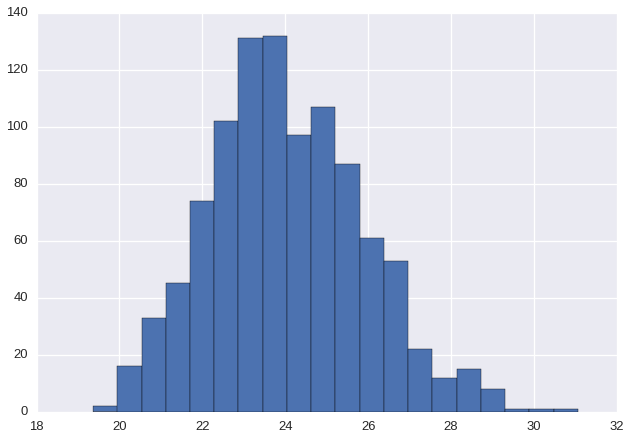

In [98]:
forecasts.iloc[20].hist(bins=20)

In [99]:
forecasts.iloc[20].mean()

24.047530312683815

#### Forecast the price action across *n* days
- Plot the mean of all possible prices for each day

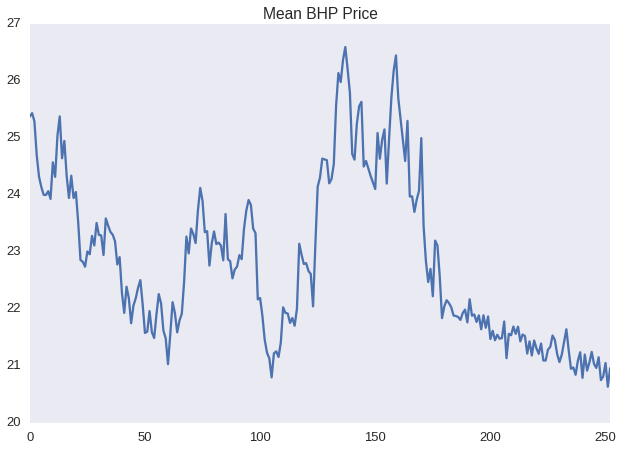

In [100]:
forecasts.mean(axis=1).plot(title="Mean BHP Price")

### Use Apache Spark

In [260]:
dayMuStd = list( enumerate(zip(muList, stdList)))

In [261]:
dayMuStd[0:10]

[(0, (-0.0058777429467083975, 0.0)),
 (1, (0.0020077054953834828, 0.011151708132200131)),
 (2, (-0.0016680656174567672, 0.010134800291809496)),
 (3, (-0.0085787994985893345, 0.016109285802705292)),
 (4, (-0.010964456451966175, 0.014936151187669066)),
 (5, (-0.010186818563621303, 0.013494414175986421)),
 (6, (-0.0093114217103048257, 0.012534495702518742)),
 (7, (-0.0080551749418638213, 0.01213647529391697)),
 (8, (-0.0064166610800871311, 0.012371128791140449)),
 (9, (-0.0065130023521522305, 0.011667590288197445))]

In [262]:
import multiprocessing
cores = multiprocessing.cpu_count()
print("Number of cores available: %s" %cores)

Number of cores available: 8


In [263]:
from pyspark import SparkContext
sc = SparkContext('local', 'pyspark')

In [264]:
dayMuStdRDD = sc.parallelize(dayMuStd,cores)

In [265]:
dayMuStdRDD.take(1)

[(0, (-0.0058777429467083975, 0.0))]

In [266]:
print("Number of simulations per day: %s" %s)

Number of simulations per day: 1000


In [267]:
%%time
pricesRDD = (dayMuStdRDD
        .map(lambda x: (x[0],[simulate(x[0],dataBHPlastPrice,x[1][0], x[1][1], lognormal) for i in range(s)]))
        .cache()
            )
prices = pricesRDD.collect()
sc.stop()

CPU times: user 338 ms, sys: 24.4 ms, total: 362 ms
Wall time: 1min 15s


In [268]:
pricesRDD.count()

253

In [270]:
data = np.concatenate([p[1] for p in prices])
data = data.reshape((n,s))

In [271]:
data

array([[ 25.37      ,  25.37      ,  25.37      , ...,  25.37      ,
         25.37      ,  25.37      ],
       [ 25.23522326,  25.72312579,  25.12118406, ...,  24.98435028,
         25.02224018,  25.1637252 ],
       [ 24.75922255,  25.13167076,  25.77632628, ...,  24.99291295,
         25.6529248 ,  24.88564697],
       ..., 
       [ 26.48365446,  26.91081413,  25.5602856 , ...,  11.52585991,
         17.0124303 ,  22.26173504],
       [ 27.41828981,  22.1125436 ,  15.08398096, ...,  33.04080361,
         18.1143927 ,  20.69521704],
       [ 26.7588975 ,  25.5000193 ,  15.35404248, ...,  20.71191827,
         16.65410299,  24.09648011]])

In [277]:
forecasts2 = pd.DataFrame(data)

In [278]:
forecasts2.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,...,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000,25.370000
1,25.235223,25.723126,25.121184,25.250732,25.963985,25.635722,25.687995,25.073339,25.204620,25.829744,...,25.674735,24.560077,25.540112,25.717099,25.021735,25.279851,24.931033,24.984350,25.022240,25.163725
2,24.759223,25.131671,25.776326,25.398199,25.062834,25.389870,25.004317,25.463604,25.051388,25.368801,...,25.962120,25.611190,24.712295,25.737651,24.877881,25.543092,24.886680,24.992913,25.652925,24.885647
3,24.063158,24.763121,25.654039,25.705430,23.239563,24.128127,24.892155,24.492818,25.408955,24.651330,...,25.028170,24.556531,23.772612,25.017711,24.158237,24.416808,23.605485,25.640516,23.815752,25.332995
4,24.168364,25.524719,24.084055,23.793946,24.487385,22.549268,24.639830,25.203059,25.411501,24.173216,...,23.770324,24.359593,24.393536,23.722849,25.183957,24.050816,24.275654,22.917785,23.844126,25.055428


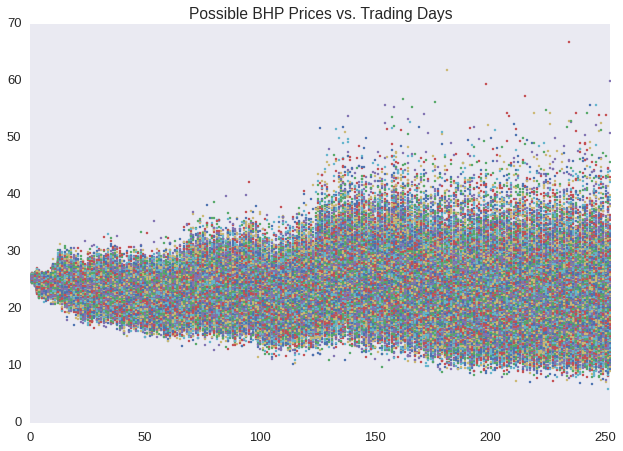

In [279]:
forecasts2.plot(style='.', legend=False, linewidth=0.5,title="Possible BHP Prices vs. Trading Days", ms=5)

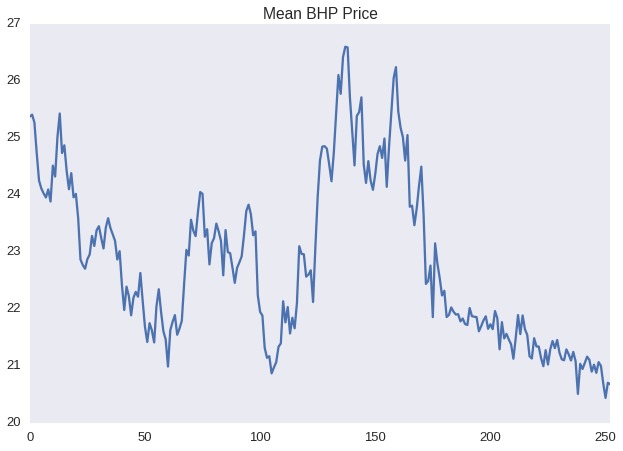

In [280]:
forecasts2.mean(axis=1).plot(title="Mean BHP Price")